In [1]:
import keras  
import tensorflow as tf
from keras.applications.vgg16 import VGG16  
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input  
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

"Construnt extracted feature model by pre-trained VGG16"
height, width = 512, 512
ext_model = VGG16(weights='imagenet', include_top=False)
Raw_path = "deep_512.h5"
Model_path = "deep_inverse_512.h5"
"Extract feature patch from block3_conv1 output "
for i in range(11):
    ext_model.layers.pop()
ext_model.outputs = [ext_model.layers[-1].output]
ext_model.layers[-1].outbound_nodes = []
"Don't train extraction model"
for layer in ext_model.layers:
    layer.trainable = False

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
"Swap feature patch "
import h5py
from keras.models import Model, load_model
from PIL import Image

def style_swap(content, style, filter_size = 3):
    height, width =content.shape[1], content.shape[2]
    "split extracted feature in filter size for row"
    rows = tf.split(style, num_or_size_splits=list(
            [filter_size] * (height // filter_size) + [width % filter_size]), axis=1)[:-1]
    "split every row in filter size for colum"
    cells = [tf.split(row, num_or_size_splits=list(
            [filter_size] * (height // filter_size) + [width % filter_size]), axis=2)[:-1]
            for row in rows]
    "collect all patch"
    stacked_cells = [tf.stack(row_cell, axis=4) for row_cell in cells]
    filters = tf.concat(stacked_cells, axis=-1)
    swaped_list = []
    for style_filter in tf.unstack(filters, axis=0, num=1):
        swaped_list.append(swap(content, style_filter, filter_size))
    
    return tf.concat(swaped_list, axis=0)

def swap(content_feature, style_feature, filter_size = 3):
    height, width  = tf.shape(content_feature)[1], tf.shape(content_feature)[2]
    normalized_filters = tf.nn.l2_normalize(style_feature, dim=(0, 1, 2))

    strides=[1,1,1,1]
    "find the most similar patch for tow images and swap them"
    similarity = tf.nn.conv2d(content_feature, normalized_filters, strides=strides, padding="VALID")
    arg_max_filter = tf.argmax(similarity, axis=-1)
    one_hot_filter = tf.one_hot(arg_max_filter, depth=similarity.get_shape()[-1].value)
    swap = tf.nn.conv2d_transpose(one_hot_filter, style_feature, output_shape=tf.shape(content_feature),
                                    strides=strides, padding="VALID")

    return swap //(filter_size**2)

def real_style_swap(real_path, style_path):
    "Test for inverse network"
    inverse_model = load_model(Model_path)

    style = Image.open(style_path)
    style = style.resize((height, width))
    style = np.asarray(style, dtype='int16')
    style = np.expand_dims(style, axis=0)
    style = preprocess_input(style)
    style = ext_model.predict(style)


    real = Image.open(real_path)
    real = real.resize((height, width))
    real = np.asarray(real, dtype='int16')
    real = np.expand_dims(real, axis=0)
    real = preprocess_input(real)
    real = ext_model.predict(real)

    with tf.Session() as sess:
        result = sess.run(style_swap(real,style, 3))
    test = inverse_model.predict(result)
    return test



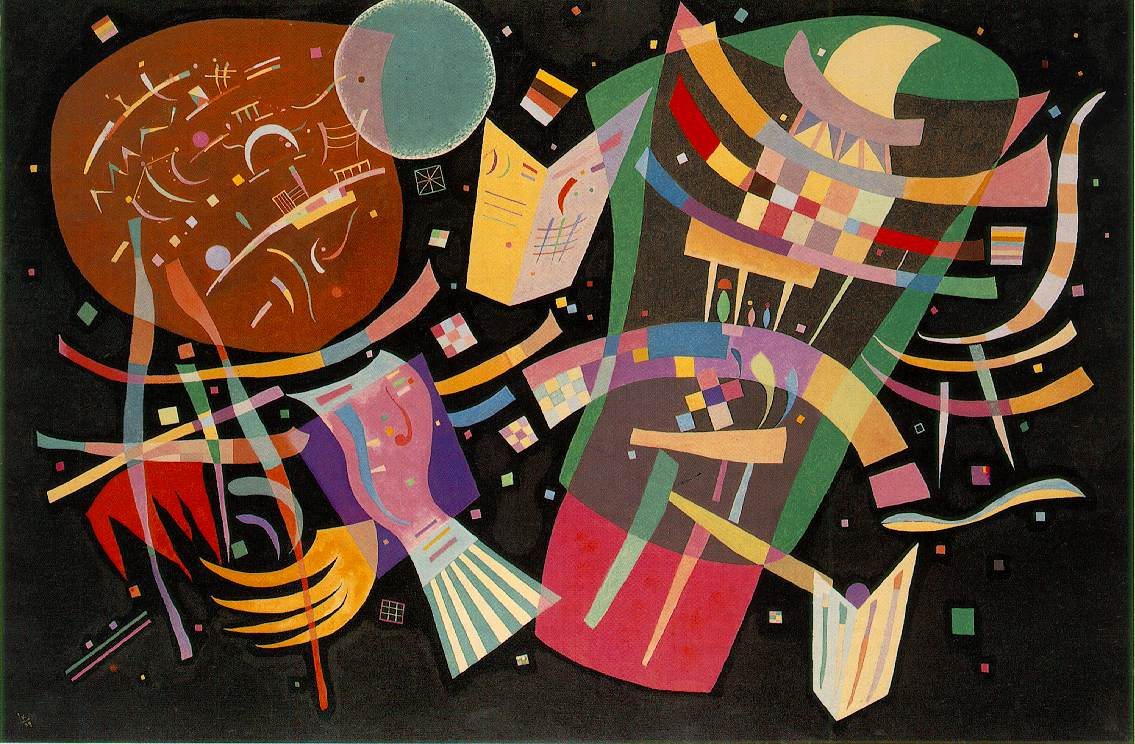

In [3]:
from IPython.display import Image as im
style_path = '/data1/home/feynman52/supvict123/style-swap/Vassily_Kandinsky,_1939_-_Composition_10.jpg'
im(filename=style_path) 
 

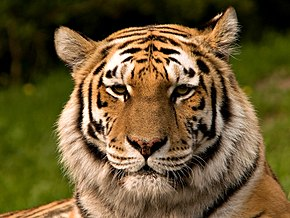

In [4]:
real_path = '/data1/home/feynman52/supvict123/style-swap/290px-Siberischer_tiger_de_edit02.jpg'
im(filename=real_path)

/data1/home/feynman52/.pyenv/versions/3.6.5/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
dim is deprecated, use axis instead


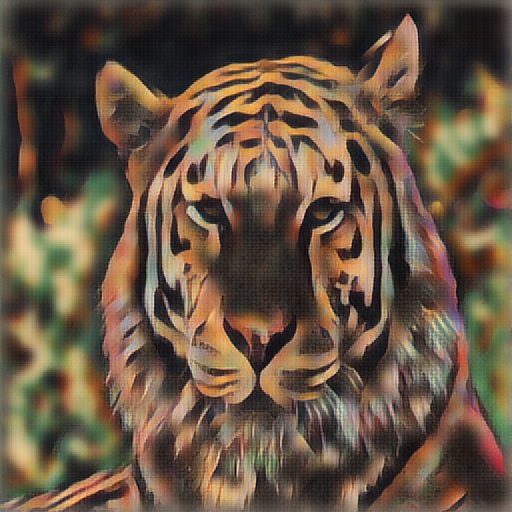

In [5]:
test = real_style_swap(real_path, style_path)
Image.fromarray(np.clip(test[0], 0, 255).astype('uint8'))